# MODELING

## RandomFlorestClassifier

### TUNING - RANDOM FOREST CLASSIFIER

In [13]:
import matplotlib.pyplot as plt
import warnings
import os
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import warnings
from data.split_data import  treino_e_teste, ajustar_threshold
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

In [14]:
# Obter o caminho absoluto da pasta src/data/processed_data
project_path = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))
src_path = os.path.join(project_path, 'src/data/processed_data')

# Carregar as variáveis de volta
X_train = joblib.load(os.path.join(src_path, 'X_train.pkl'))
X_test = joblib.load(os.path.join(src_path, 'X_test.pkl'))
y_train = joblib.load(os.path.join(src_path, 'y_train.pkl'))
y_test = joblib.load(os.path.join(src_path, 'y_test.pkl'))

print("Dados carregados com sucesso!")

Dados carregados com sucesso!


In [15]:
# Obter o caminho absoluto da pasta src/data/interim
project_path = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))
src_path = os.path.join(project_path, 'src/data/interim')

X_resampled = joblib.load(os.path.join(src_path, 'X_resampled.pkl'))
y_resampled = joblib.load(os.path.join(src_path, 'y_resampled.pkl'))
# Carregar o modelo treinado

In [16]:
# Certificar-se de que as classes estão em formato binário
y_resampled = y_resampled.map({"Yes": 1, "No": 0})

Ajuste de hiperparâmetros

```python

rf_grid = RandomForestClassifier(random_stat = Controla a aleatoriedade, garantindo reprodutibilidade dos resultados,
                                 oob_score= Habilita a validação fora da amostra (out-of-bag) para estimar a performance
                                 )

param_grid = {
    'n_estimators': [Número de árvores na floresta. Mais árvores podem melhorar a performance, mas aumentam o tempo de treinamento.],       
    'max_depth': [Profundidade máxima de cada árvore. Limitar a profundidade evita overfitting.],           
    'min_samples_split': [Número mínimo de amostras necessárias para dividir um nó. Valores maiores reduzem o overfitting.],  
    'min_samples_leaf': [Número mínimo de amostras por folha. Valores maiores ajudam a regularizar o modelo.],   
    'max_features': [Número de recursos considerados para determinar o melhor split. Pode ser 'auto', 'sqrt', ou 'log2', além de valores numéricos.]       
}

# Configurar o GridSearchCV
grid_search = GridSearchCV(
    estimator = Modelo base para ajuste (neste caso, o RandomForestClassifier),
    param_grid = Dicionário com os hiperparâmetros a serem ajustados,
    scoring = Métrica de avaliação usada para comparar os modelos (ex.: 'accuracy', 'roc_auc'),
    cv = Número de divisões para validação cruzada. Define a robustez da avaliação
)
```
##### Documentação:
[scikit-learn - GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)  
[scikit-learn - RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)


In [17]:
# Ignorar warnings desnecessários
warnings.filterwarnings("ignore", message="Bins whose width are too small")

y_resampled_copy = y_resampled.copy()
y_test_copy = y_test.copy()
X_resampled_copy = X_resampled.copy()

# Agora, mapeie os valores de 'Yes'/'No' para 1/0 nas cópias
y_resampled_copy = y_resampled_copy.map({"Yes": 1, "No": 0})
y_test_copy = y_test_copy.map({"Yes": 1, "No": 0})


# Modelo base
rf_grid = RandomForestClassifier(random_state=42, oob_score=True)

# Parâmetros para o GridSearchCV com peso das classes
param_grid = {
    'n_estimators': [50, 100],            # Número de árvores
    'max_depth': [5, 10],                 # Profundidade da árvore
    'min_samples_split': [2, 5],          # Mínimo de amostras para dividir um nó
    'min_samples_leaf': [2, 5],           # Mínimo de amostras em um nó folha
    'max_features': ['sqrt', 'log2'],     # Seleção de recursos
    'class_weight': [                     # Pesos para lidar com desbalanceamento
         'balanced',                       # Balancear automaticamente com base nos dados
          None                              # Sem ajuste de peso
    ]
}

# Configurar o GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_grid,
    param_grid=param_grid,
    scoring='f1',  # Métrica alvo: recall
    cv=5             # Validação cruzada com 3 folds

)

# Treinar o GridSearchCV
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_model_rf = grid_search.best_estimator_

# Previsões e avaliação
y_pred_grid_rf = best_model_rf.predict(X_test)

# Exibir os melhores parâmetros e desempenho
print("Melhores Parâmetros:", grid_search.best_params_)


Melhores Parâmetros: {'class_weight': None, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


### MODELAGEM MATEMÁTICA: RANDOM FOREST


A previsão final é baseada na votação majoritária (classificação) ou na média das predições (regressão) das árvores individuais e isso ajuda amelhorar a estabilidade do modelo.

 $
 \hat{y} = \text{majority\_vote}(T_1(X), T_2(X), \ldots, T_T(X))
 $


- Cada árvore é construída com uma amostra de bootstrap dos dados, e, em cada nó, um subconjunto aleatório de features é selecionado para decidir a melhor divisão.

 - **Função Objetivo Implícita**:  

   - O Random Forest não minimiza explicitamente uma função de custo, mas seu objetivo implícito é:

     - **Reduzir o viés**: Árvores profundas capturam padrões complexos nos dados.

     - **Reduzir a variância**: O ensemble de múltiplas árvores aleatórias reduz a dependência de qualquer amostra específica.

        $
        \text{Erro do modelo} = \text{Viés} + \text{Variância} + \text{Erro Aleatório}
        $

 - **Importância das Features**:
   - O Random Forest avalia a importância de cada feature com base na redução da impureza (Gini ou entropia) em todas as árvores.
   - A importância de uma feature $X_j$ é calculada como:

     $
      \text{Importância de } X_j = \frac{1}{T} \sum_{t=1}^T \Delta I(X_j, t)
      $

  - Onde:
     - $\Delta I(X_j, t)$ é a redução na impureza na árvore t ao dividir com $X_j$.

     - T é o número total de árvores no ensemble.

 - **Fórmula da Previsão Final**:
	 - A predição final para classificação é baseada na maioria dos votos das árvores:

       $
       \hat{y} = \arg\max_k \frac{1}{T} \sum_{t=1}^T \mathbb{1}[T_t(X) = k]
       $

     - Descrição após a fórmula:
       - $T_t(X)$: Previsão da t-ésima árvore para a entrada X.

       - $k$: Classes possíveis.

       - $\mathbb{1}[T_t(X) = k]$: Função indicadora que retorna $1$ se $T_t(X)$ prediz k.

### TREINAMENTO DO MODELO DE CLASSIFICAÇÃO COM RANDOM FOREST

# Treinamento do Modelo Random Forest

```python
model_rf = RandomForestClassifier(
    n_estimators = Define o número de árvores no modelo. Mais árvores tornam as previsões mais estáveis,
    max_depth = Controla o quão profundas as árvores podem ser, impedindo que aprendam detalhes excessivos que podem não se repetir (ruído),
    min_samples_split = Determina o número mínimo de exemplos necessários para dividir um nó em dois,
    min_samples_leaf = Garante que cada nó final (folha) tenha pelo menos 2 exemplos, evitando divisões que analisam dados muito específicos,
    max_features = Faz com que cada árvore analise apenas uma parte das informações disponíveis, promovendo mais diversidade no modelo,
    oob_score = Valida automaticamente as previsões usando dados que não foram usados para treinar as árvores, verificando a precisão do modelo,
    bootstrap = Permite que cada árvore seja treinada com uma amostra aleatória dos dados, aumentando a independência entre elas,
    random_state = Garante que os resultados sejam reproduzíveis ao repetir o experimento,
    class_weight = Aplica ajustes automáticos para dados desbalanceados
)
```
##### Documentação:
[scikit-learn - RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  
[scikit-learn - plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)



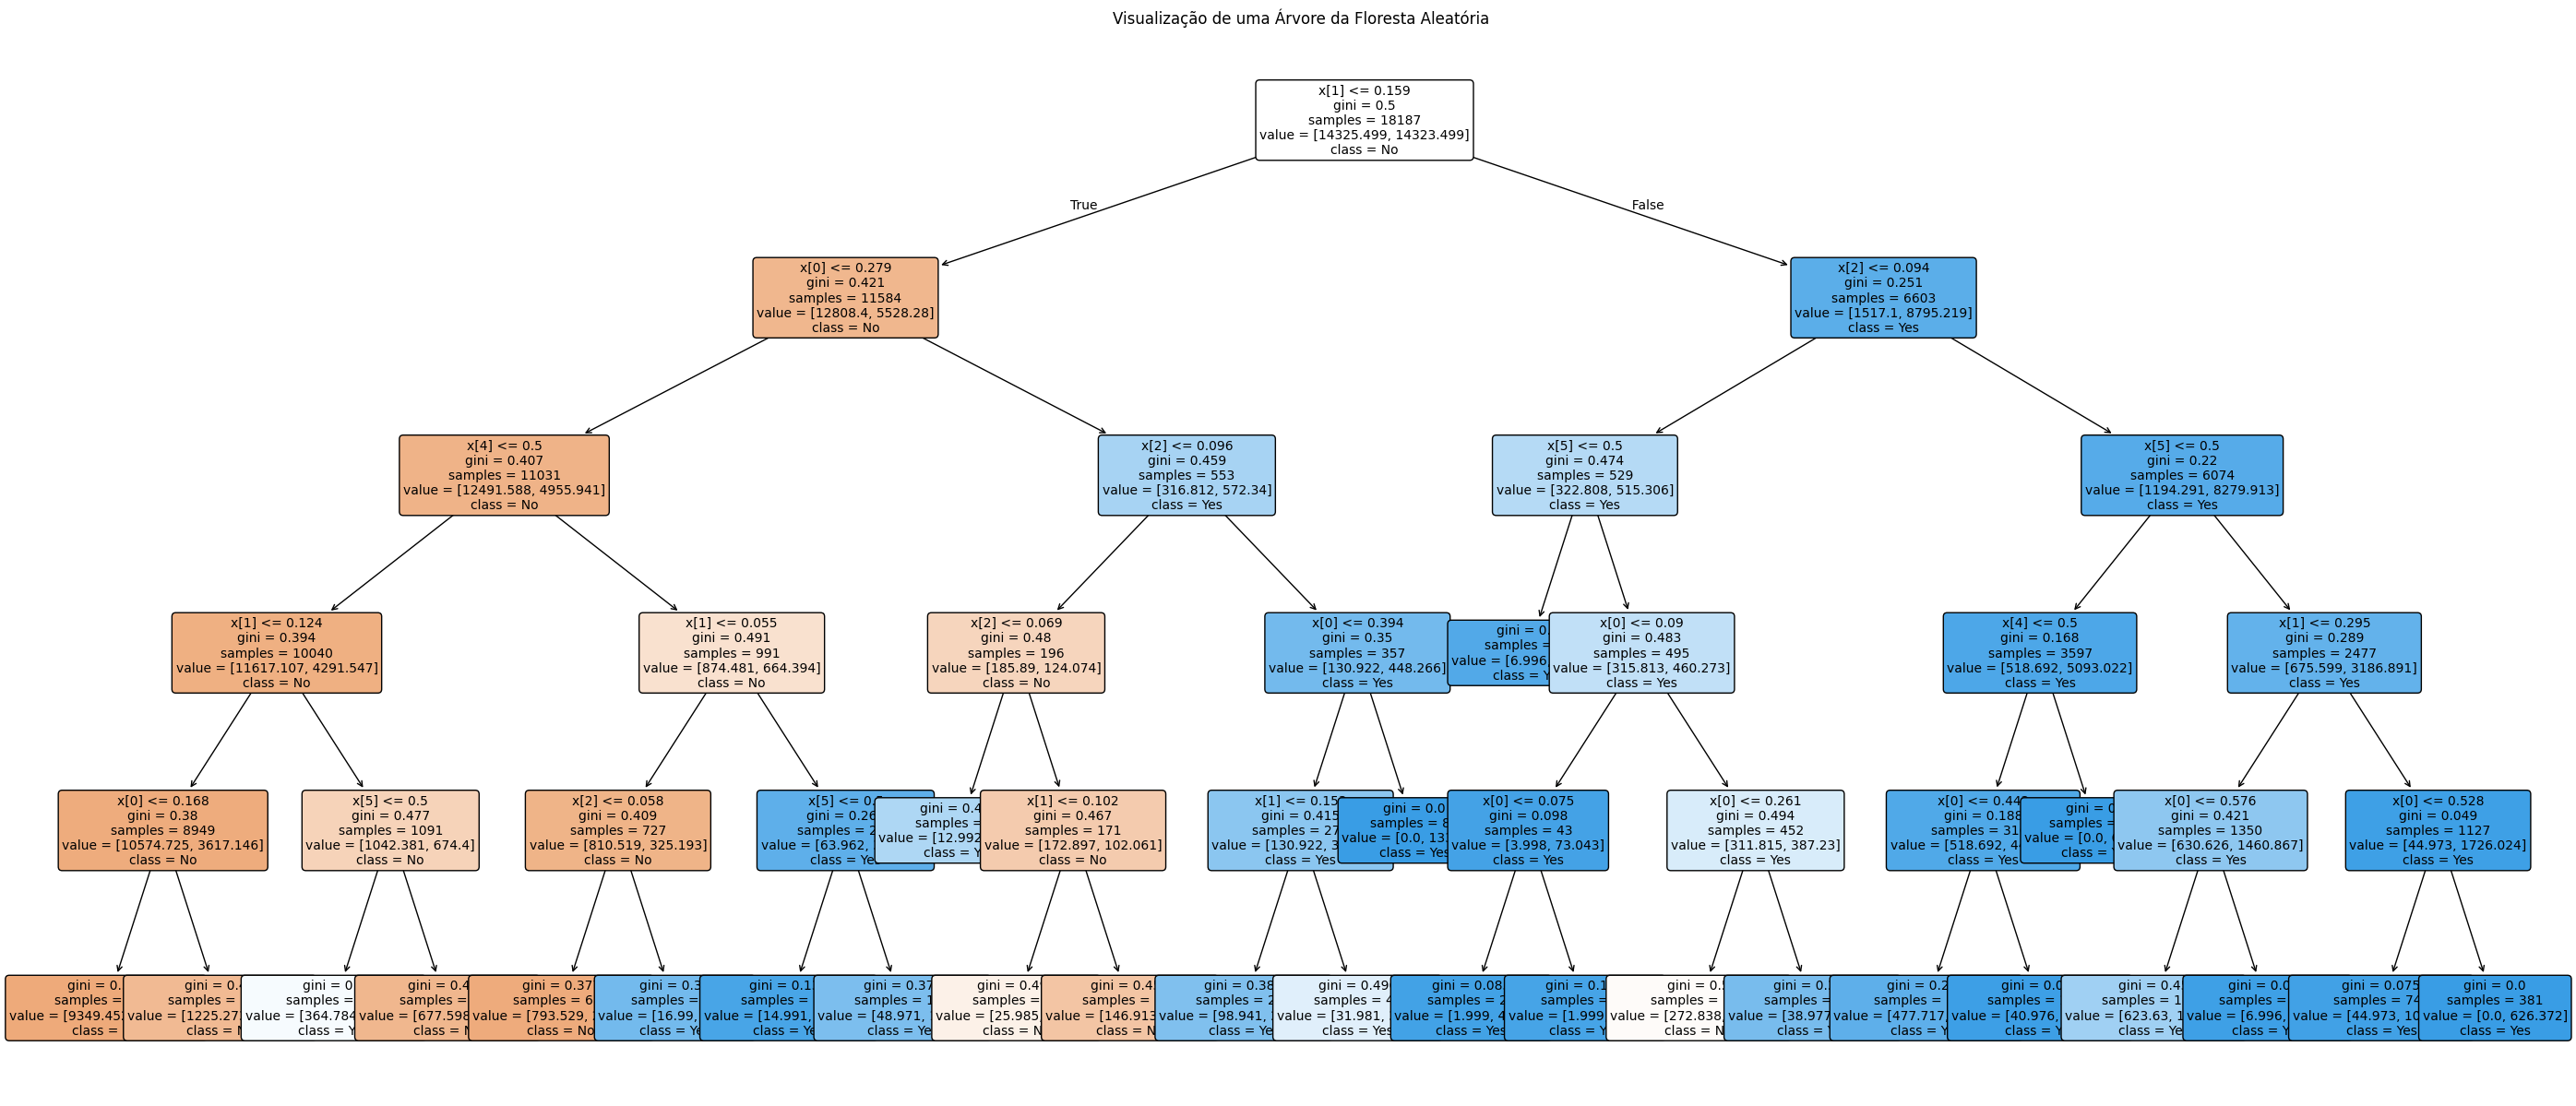

In [18]:
# Treinar o modelo Random Forest com os dados balanceados e transformados
model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=20,
    max_features='sqrt',
    oob_score=True,
    bootstrap=True,
    random_state=42,
    class_weight='balanced'  # Lidar com classes desbalanceadas
)
model_rf.fit(X_train, y_train)
warnings.filterwarnings("ignore", message="Bins whose width are too small")

# Selecionar uma árvore individual da floresta
tree = model_rf.estimators_[0]  # Seleciona a primeira árvore como exemplo

# Fazer previsões no conjunto de teste
y_pred_rf = model_rf.predict(X_test)

# Configurar o tamanho do gráfico
plt.figure(figsize=(35, 15))

# Plotar a árvore
plot_tree(
    tree,
    class_names=['No', 'Yes'],
    filled=True,
    rounded=True,
    fontsize=10
)


# Mostrar o gráfico
plt.title("Visualização de uma Árvore da Floresta Aleatória")
plt.show()

### VALIDAÇÃO CRUZADA

##### Validação cruzada pela diferença dos resultados entre treino e teste
##### Documentação:
[scikit-learn - precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)  

In [19]:
treino_e_teste(model_rf, X_train, y_train, X_test, y_test)

Métrica,TREINO,TESTE
Acurácia,0.7879,0.7854
Precisão,0.8007,0.7984
Recall,0.7879,0.7854
F1-Score,0.7856,0.7831


##### Validação cruzada utilizando **_cross_val_score_**

##### Documentação:
[scikit-learn - cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)  
[scikit-learn - LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [20]:
# Realizar validação cruzada
cv_scores = cross_val_score(model_rf, X_resampled, y_resampled, cv=10, scoring='accuracy')  # Usa 5 folds

# Exibir os resultados
print("Scores de validação cruzada:", cv_scores)
print("Média dos scores:", cv_scores.mean())
print("Desvio padrão dos scores:", cv_scores.std())

Scores de validação cruzada: [0.60022334 0.84505863 0.83216978 0.83719631 0.82602625 0.81206367
 0.78274225 0.73359397 0.68863446 0.59313041]
Média dos scores: 0.7550839072335832
Desvio padrão dos scores: 0.09214808759272634


### PONTO DE CORTE ÓTIMO - **_THRESHOLD_**

Em muitos modelos, o _threshold_ padrão tem o valor em 0.5, tendo em vista que a divisão natural das classes ocorre no meio.
Entretanto, mesmo que os dados tenham sido balanceados e igualadas as classes, o valor de 0.5 como corte pode não ser ótimo, especialmente com diferentes custos associados a falsos positivos e falsos negativos.
O ponto de corte ótimo é aquele que maximiza ou equilibra métricas importantes para o problema, portanto threshold escolhido foi baseado nos objetivos estratégicos:

- Maximizar recall: Garantir que o maior número possível de clientes em risco fosse identificado.

- Minimizar falsos negativos: Reduzir o impacto financeiro de ignorar um cliente em risco.

- Equilíbrio com precisão: Evitar alocar recursos desnecessários para clientes que não churnariam.

- 1.	**Geração de thresholds**:
- Foram gerados 50 valores uniformemente espaçados entre 0 e 1, representando possíveis limiares de decisão.
- 2.	**Cálculo do F1-score**:
- Para cada threshold, as probabilidades previstas ($y\_prob$) foram ajustadas para gerar previsões binárias ($y\_pred$).
O F1-score foi calculado para cada threshold, considerando:
- **Precision**: O quão preciso o modelo é ao prever positivos.
- **Recall**: O quanto o modelo identifica corretamente os positivos.
- 3.	**Identificação do threshold ótimo**:
O threshold que maximiza o F1-score foi selecionado como o threshold ótimo:
```python
threshold_otimo = thresholds[np.argmax(f1_scores)]
```
##### Documentação:
[scikit-learn - precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)


Gráfico de métricas salvo em: /Users/rodrigocampos/Documents/Pandas/Desafio06/Churned/project/reports/figures/Métricas em função de Threshold RandomForest_threshold_metrics_recall.png


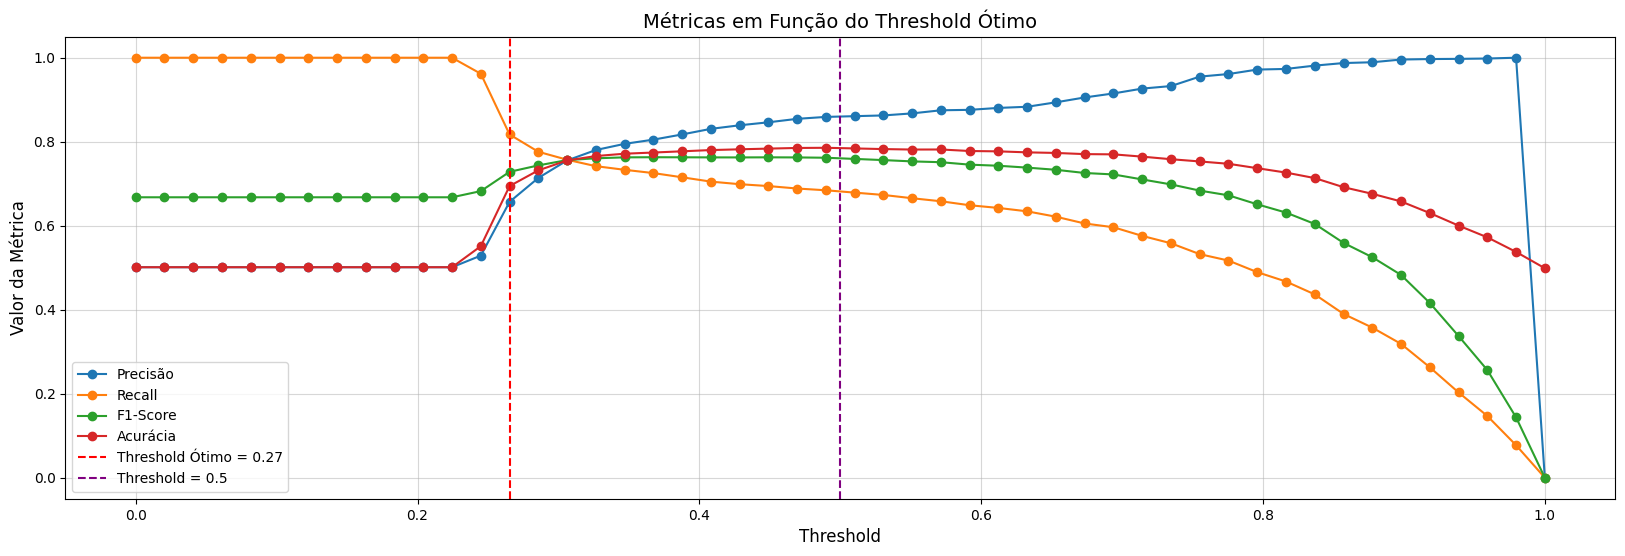

Gráfico de sensibilidade/especificidade salvo em: /Users/rodrigocampos/Documents/Pandas/Desafio06/Churned/project/reports/figures/Métricas em função de Threshold RandomForest_sensitivity_specificity.png


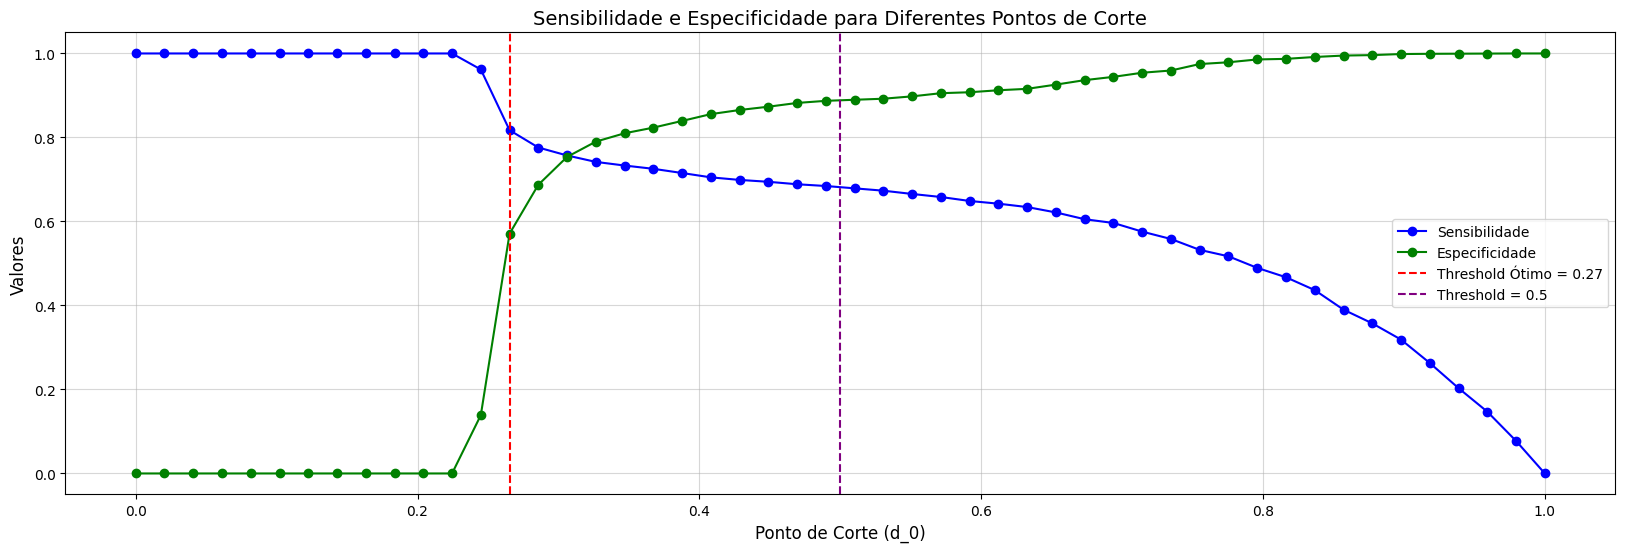


Threshold Ótimo (Precision >= 60.0%): 0.2653
Melhor Recall com Threshold Ótimo: 0.8173


In [21]:
optimal_threshold, y_pred_th_otimo, y_prob_th = ajustar_threshold(model_rf, X_train, X_test, y_train, y_test, threshold_precision=0.6, metric='recall', model_name='Métricas em função de Threshold RandomForest')

In [22]:
optimal_threshold_rf = optimal_threshold
y_pred_th_otimo_rf = y_pred_th_otimo
y_prob_th_rf = y_prob_th

In [23]:
# Obter o caminho absoluto do diretório do projeto
project_path = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))

# Caminho completo para a pasta src/data/processed_data
src_path = os.path.join(project_path, 'src/data/processed_data')
os.makedirs(src_path, exist_ok=True)

# Salvar arquivos diretamente na pasta correta

joblib.dump(y_pred_rf, os.path.join(src_path, 'y_pred_rf.pkl'))
joblib.dump(y_pred_th_otimo_rf, os.path.join(src_path, 'y_pred_th_otimo_rf.pkl'))
joblib.dump(y_prob_th_rf, os.path.join(src_path, 'y_prob_th_rf.pkl'))


print("Dados salvos com sucesso!")

Dados salvos com sucesso!


In [24]:
# Obter o caminho absoluto do diretório do projeto
project_path = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))

# Caminho completo para a pasta src/models/train_saved
src_path = os.path.join(project_path, 'src/models/train_saved')
os.makedirs(src_path, exist_ok=True)

# Salvar arquivos diretamente na pasta correta
joblib.dump(model_rf, os.path.join(src_path, 'model_rf.pkl'))
joblib.dump(optimal_threshold_rf, os.path.join(src_path, 'optimal_threshold_rf.pkl'))

print("Dados salvos com sucesso!")

Dados salvos com sucesso!
